In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.decomposition import PCA

Select a set of grayscale images (e.g., faces, landscapes, or any other category). Normalize the images by scaling pixel values to a range [0, 1].

In [3]:
# Function to load images without resizing and skipping portrait images
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return np.array(images)

# Load images
folder_path = '../data/archive/train/happy'
images = load_images(folder_path)
print(f"Loaded {len(images)} images with shape {images[0].shape}")


Loaded 7215 images with shape (48, 48)


# PCA Implementation
Write a Python function to perform PCA on the images. Implement the following steps:

### Convert the image into a 2D matrix where each row represents an image and each column represents a pixel value.

In [4]:
# Flatten the images to 2D matrix (num_images, num_pixels)
image_matrix = images.reshape(images.shape[0], -1)  # num_images x (height * width)
print(f"Image matrix shape: {image_matrix.shape}")


Image matrix shape: (7215, 2304)


### Compute the covariance matrix of the image data.

In [5]:
# Compute the covariance matrix
cov_matrix = np.cov(image_matrix, rowvar=False)  # Columns represent variables (pixels)
print(f"Covariance matrix shape: {cov_matrix.shape}")


Covariance matrix shape: (2304, 2304)


### Calculate the eigenvalues and eigenvectors of the covariance matrix.

In [6]:
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
print(f"Eigenvalues shape: {eigenvalues.shape}, Eigenvectors shape: {eigenvectors.shape}")


Eigenvalues shape: (2304,), Eigenvectors shape: (2304, 2304)


### Sort the eigenvectors based on the eigenvalues in descending order

In [7]:
# Sort eigenvectors based on eigenvalues in descending order
idx = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, idx]
sorted_eigenvalues = eigenvalues[idx]


### Select the top k eigenvectors to form the principal components.

In [8]:
# Select top k principal components
# Number of components needed to explain 95% variance: 1125
# Number of components needed to explain 99% variance: 3349
k = len(sorted_eigenvalues) // 10  # Adjust based on the desired number of components
top_k_eigenvectors = sorted_eigenvectors[:, :k]
print(f"Selected top {k} eigenvectors shape: {top_k_eigenvectors.shape}")


Selected top 230 eigenvectors shape: (2304, 230)


### Project the original images onto the lower-dimensional subspace defined by the selected principal components.

In [9]:
# Project the original images onto the lower-dimensional subspace
projected_data = np.dot(image_matrix, top_k_eigenvectors)
print(f"Projected data shape: {projected_data.shape}")


Projected data shape: (7215, 230)


# Reconstruction of Images

### Using the selected principal components, reconstruct the images.

In [10]:
reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions



### Compare the reconstructed images with the original images to observe the effects of dimensionality reduction.

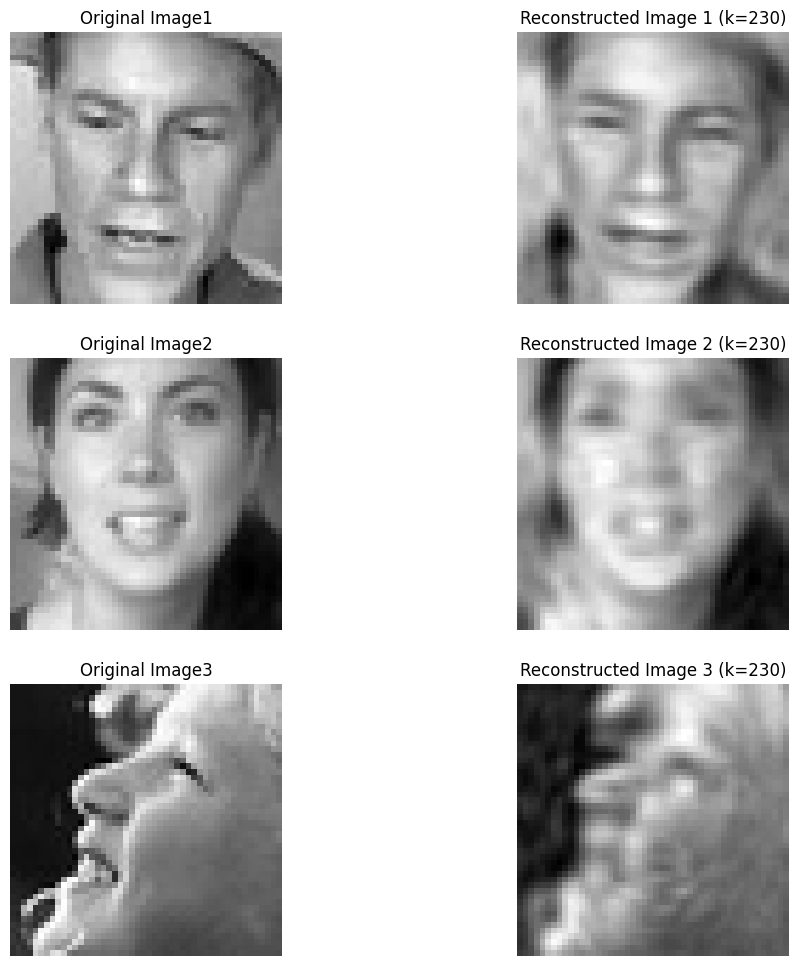

In [11]:
# Number of images to display
num_images_to_display = 3

# Create a figure with subplots
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(12, 4 * num_images_to_display))

for i in range(num_images_to_display):
    # Original image
    axes[i, 0].imshow(images[i + 420 + 17], cmap='gray')
    axes[i, 0].set_title('Original Image' + str(i + 1))
    axes[i, 0].axis('off')
    
    # Reconstructed image
    axes[i, 1].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
    axes[i, 1].set_title(f'Reconstructed Image {str(i + 1)} (k={k})')
    axes[i, 1].axis('off')

# Adjust layout
# plt.tight_layout()
plt.show()

# Experimentation

### Vary the number of principal components (k) and observe the impact on the quality of the reconstructed images.

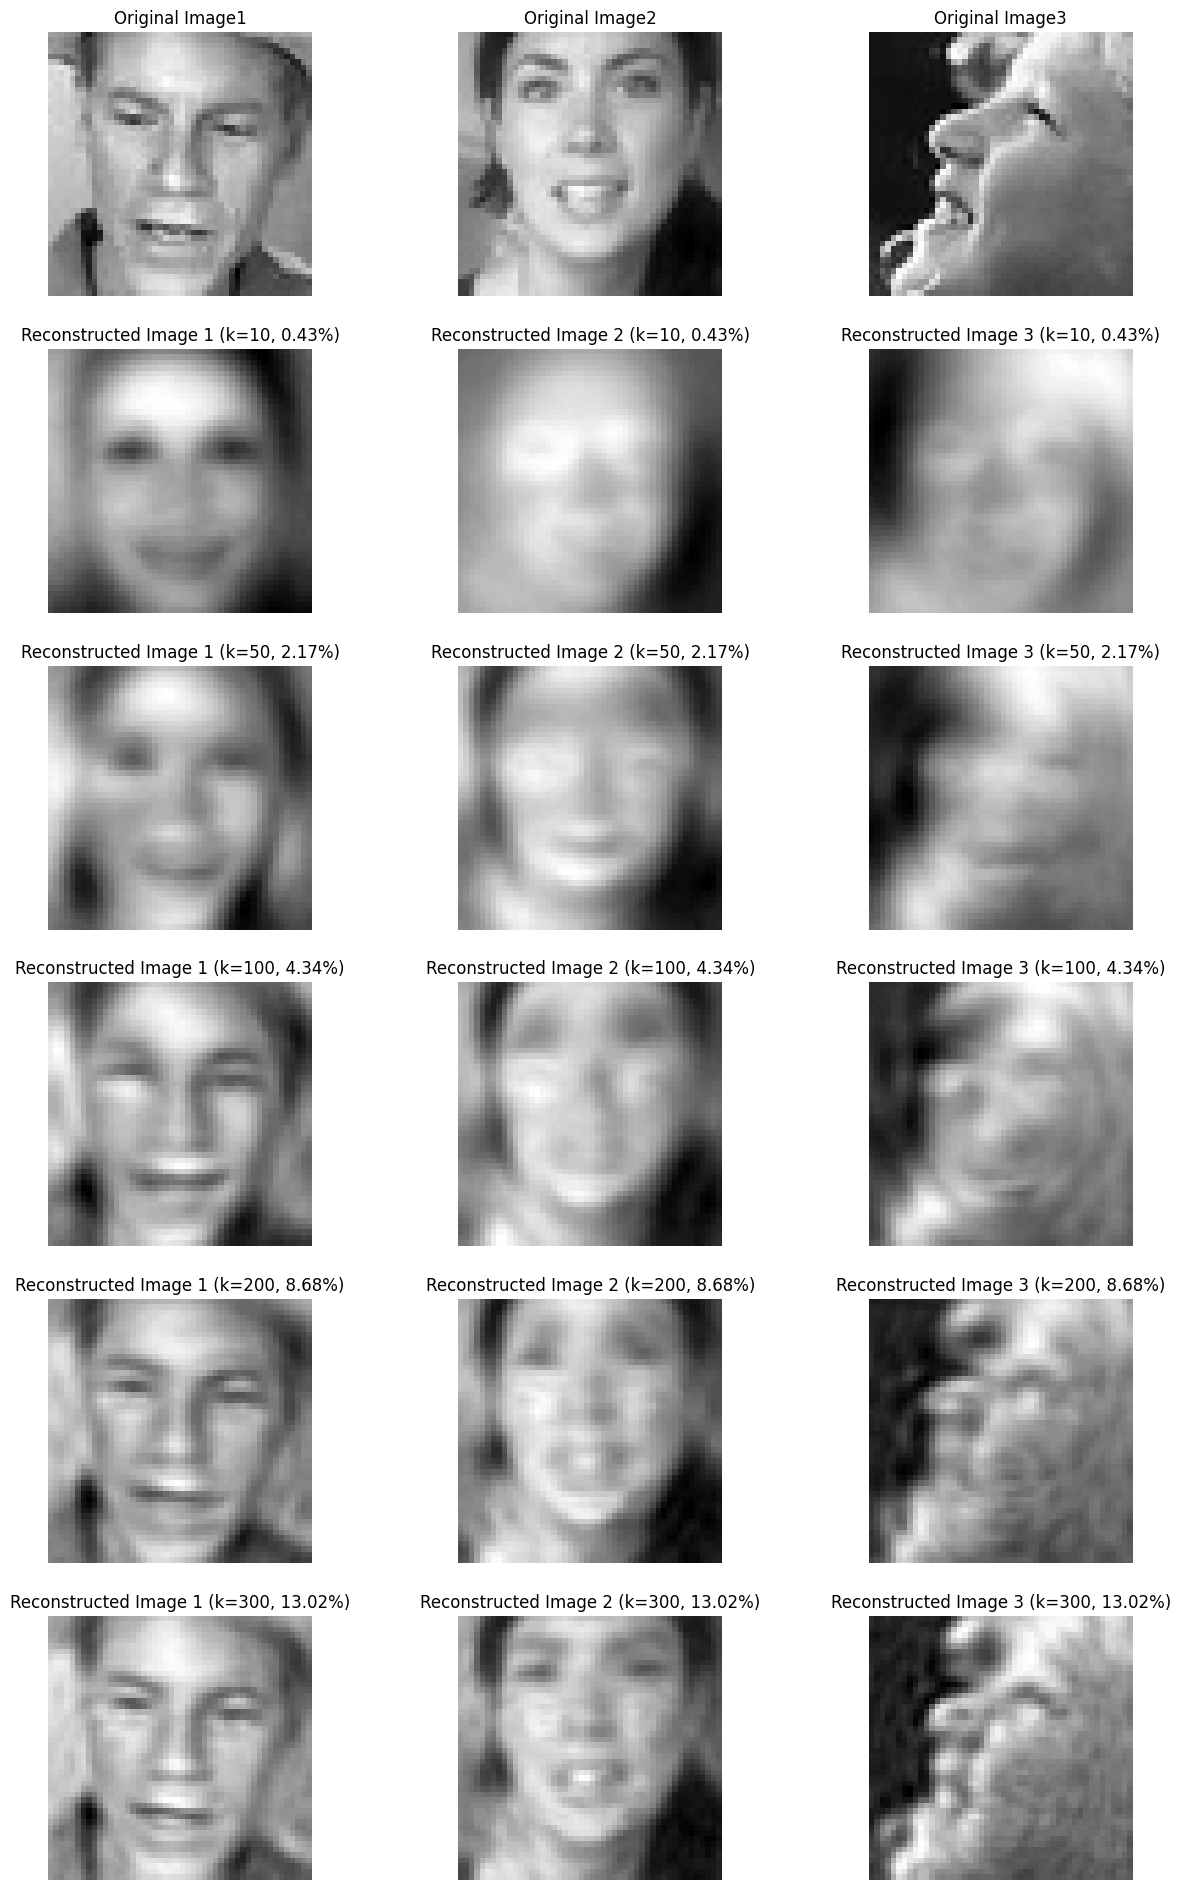

In [12]:
def vary(k_values):
    num_images_to_display = 3
    num_k_values = len(k_values)
    total_components = len(sorted_eigenvalues)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_k_values + 1, num_images_to_display, figsize=(5 * num_images_to_display, 4 * (num_k_values + 1)))
    
    for i in range(num_images_to_display):
        # Display original image
        axes[0, i].imshow(images[i + 420 + 17], cmap='gray')
        axes[0, i].set_title('Original Image' + str(i + 1))
        axes[0, i].axis('off')
        
        for j, k in enumerate(k_values):
            top_k_eigenvectors = sorted_eigenvectors[:, :k]
            projected_data = np.dot(image_matrix, top_k_eigenvectors)
            reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
            reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
            
            # Calculate percentage of total components
            percentage = (k / total_components) * 100
            
            # Display reconstructed image
            axes[j + 1, i].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
            axes[j + 1, i].set_title(f'Reconstructed Image {str(i + 1)} (k={k}, {percentage:.2f}%)')
            axes[j + 1, i].axis('off')
    
    plt.show()

# Example usage
k_values = [10, 50, 100, 200, 300] 
vary(k_values)


### Plot the variance explained by the principal components and determine the optimal number of components that balances compression and quality

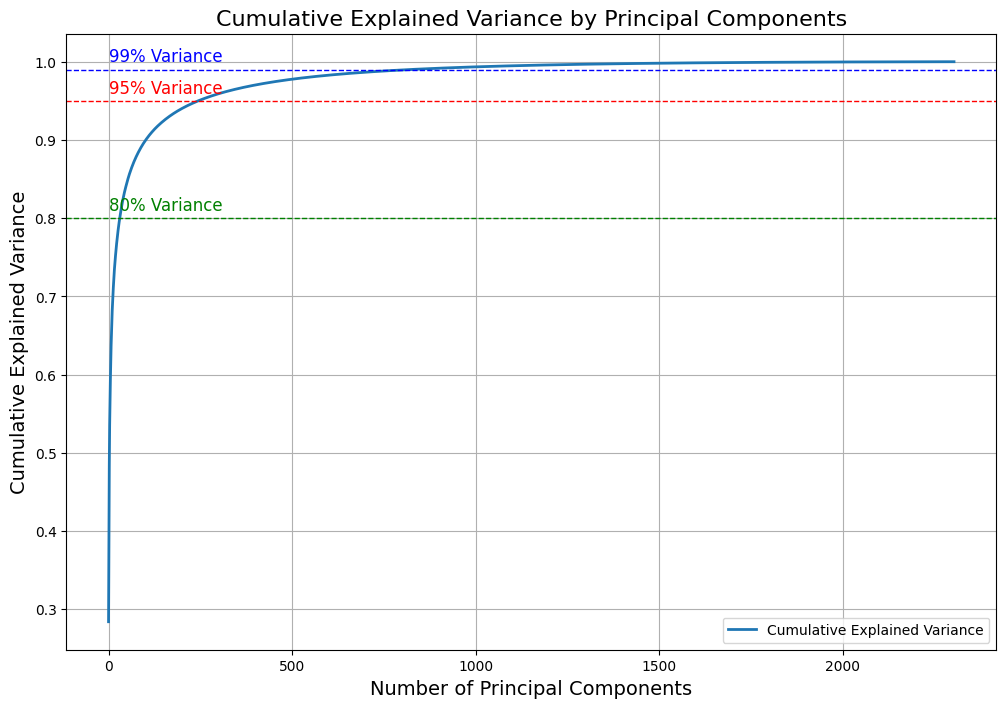

Number of components needed to explain 80% variance: 32
Number of components needed to explain 95% variance: 246
Number of components needed to explain 99% variance: 822


In [13]:
# Step 1: Apply PCA
pca = PCA()
pca.fit(image_matrix)

# Step 2: Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 3: Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Step 4: Plot cumulative explained variance
plt.figure(figsize=(12, 8))
plt.plot(cumulative_explained_variance, linestyle='-', linewidth=2, label='Cumulative Explained Variance')

# Add horizontal lines for 80%, 95%, and 99% variance explained
plt.axhline(y=0.80, color='g', linestyle='--', linewidth=1)
plt.text(0.5, 0.81, '80% Variance', color='green', fontsize=12)

plt.axhline(y=0.95, color='r', linestyle='--', linewidth=1)
plt.text(0.5, 0.96, '95% Variance', color='red', fontsize=12)

plt.axhline(y=0.99, color='b', linestyle='--', linewidth=1)
plt.text(0.5, 1.00, '99% Variance', color='blue', fontsize=12)

# Add labels and title
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)
plt.title('Cumulative Explained Variance by Principal Components', fontsize=16)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Step 5: Determine the optimal number of components for 80%, 95%, and 99% variance
optimal_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
optimal_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
optimal_components_99 = np.argmax(cumulative_explained_variance >= 0.99) + 1

print(f'Number of components needed to explain 80% variance: {optimal_components_80}')
print(f'Number of components needed to explain 95% variance: {optimal_components_95}')
print(f'Number of components needed to explain 99% variance: {optimal_components_99}')


# Visual Analysis

### Display the original images alongside the reconstructed images for different values of k.

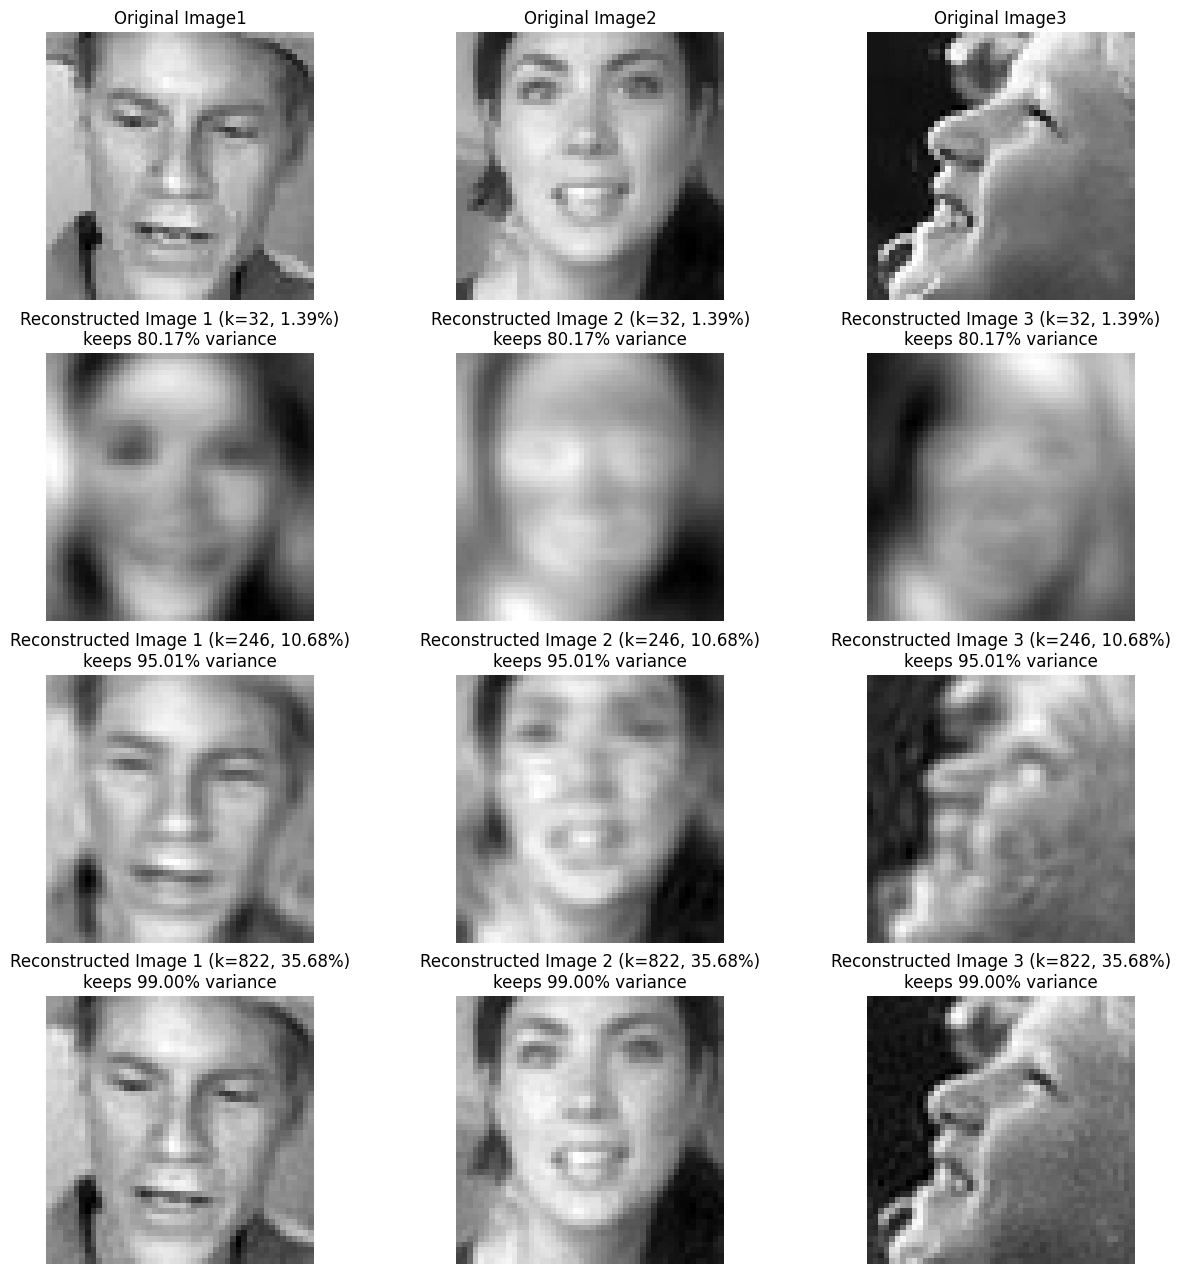

In [14]:
def vary(k_values):
    num_images_to_display = 3
    num_k_values = len(k_values)
    total_components = len(sorted_eigenvalues)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_k_values + 1, num_images_to_display, figsize=(5 * num_images_to_display, 4 * (num_k_values + 1)))
    
    for i in range(num_images_to_display):
        # Display original image
        axes[0, i].imshow(images[i + 420 + 17], cmap='gray')
        axes[0, i].set_title('Original Image' + str(i + 1))
        axes[0, i].axis('off')
        
        for j, k in enumerate(k_values):
            top_k_eigenvectors = sorted_eigenvectors[:, :k]
            projected_data = np.dot(image_matrix, top_k_eigenvectors)
            reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
            reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
            
            # Calculate percentage of total components
            percentage = (k / total_components) * 100
            
            # Display reconstructed image
            axes[j + 1, i].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
            axes[j + 1, i].set_title(f'Reconstructed Image {str(i + 1)} (k={k}, {percentage:.2f}%)\nkeeps {cumulative_explained_variance[k - 1] * 100:.2f}% variance')
            axes[j + 1, i].axis('off')
    
    plt.show()

# Example usage
k_values = [32, 246, 822] # 80, 95, and 99% variance explained
vary(k_values)


### Comment on the visual quality of the images and how much information is lost during compression.

# Error Analysis

### Compute the Mean Squared Error (MSE) between the original and reconstructed images.

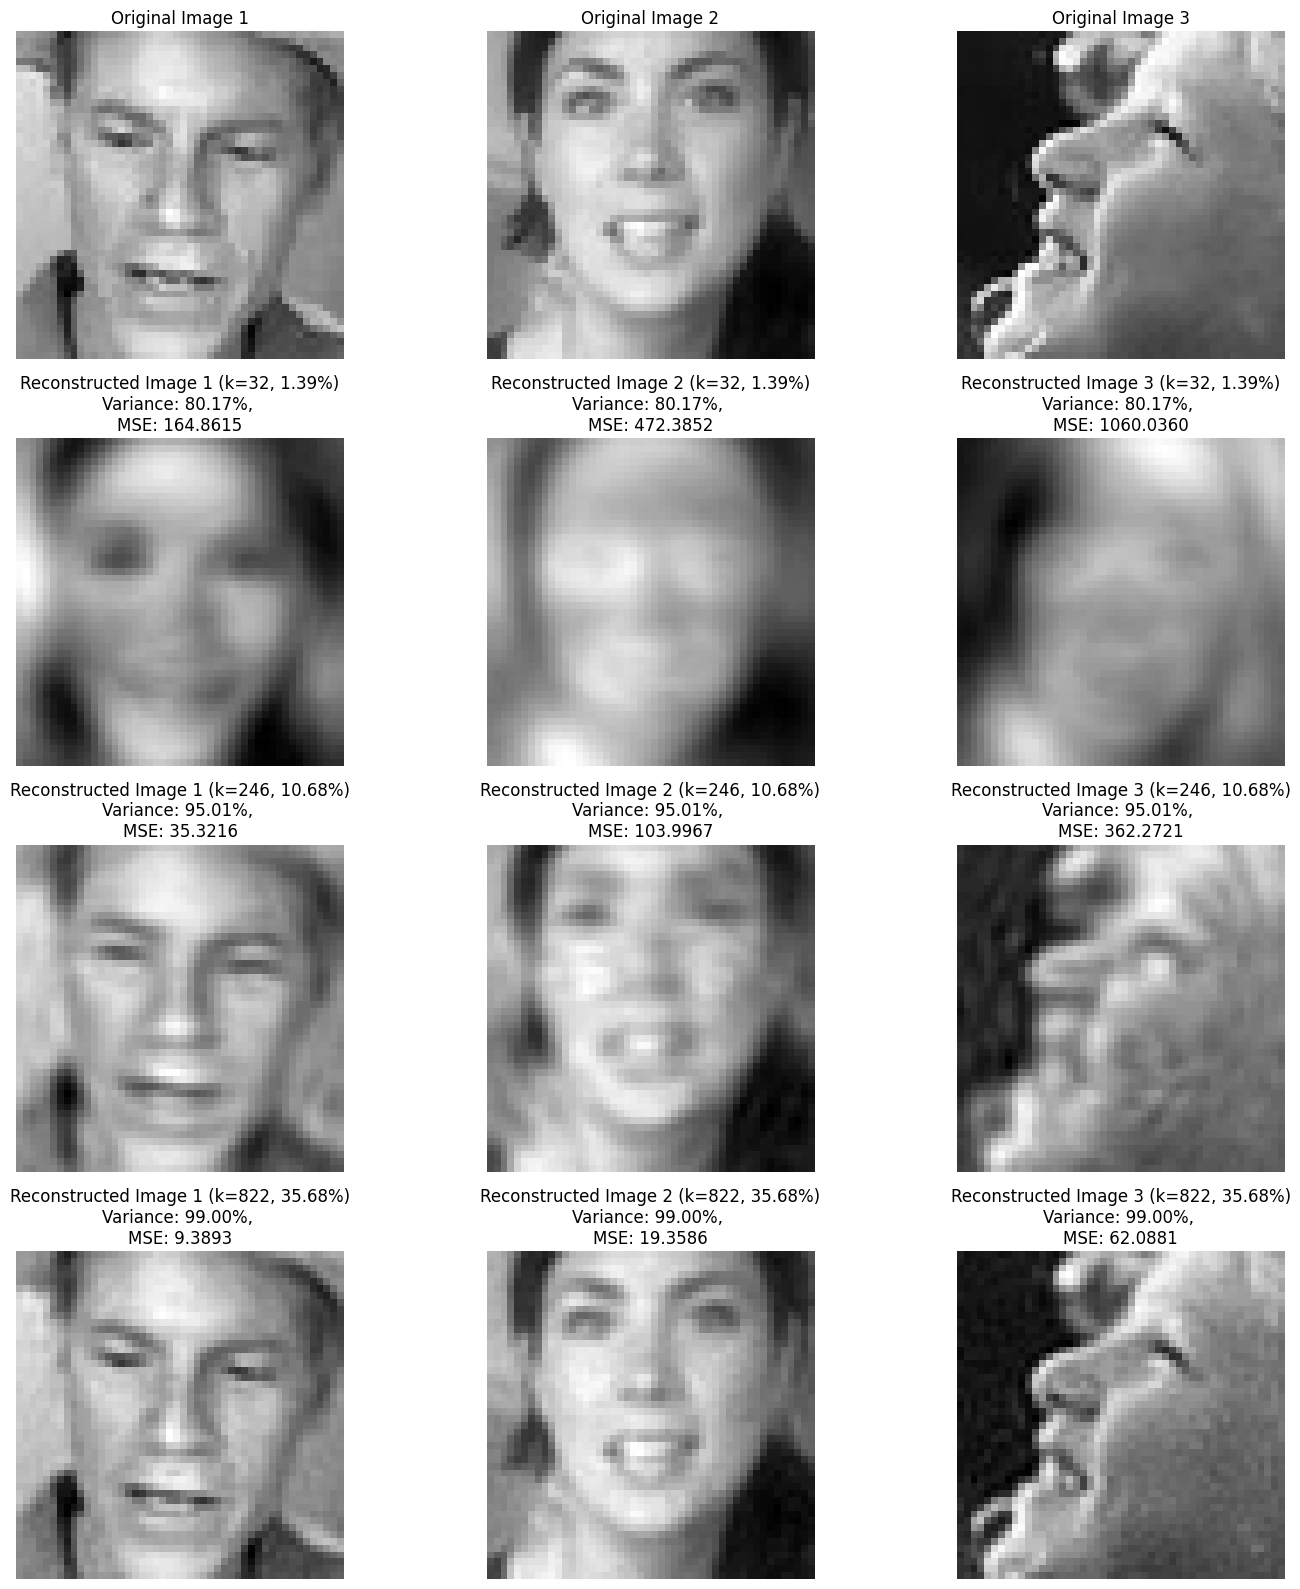

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def vary(k_values):
    num_images_to_display = 3
    num_k_values = len(k_values)
    total_components = len(sorted_eigenvalues)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_k_values + 1, num_images_to_display, figsize=(5 * num_images_to_display, 4 * (num_k_values + 1)))
    
    for i in range(num_images_to_display):
        # Display original image
        axes[0, i].imshow(images[i + 420 + 17], cmap='gray')
        axes[0, i].set_title('Original Image ' + str(i + 1))
        axes[0, i].axis('off')
        
        for j, k in enumerate(k_values):
            top_k_eigenvectors = sorted_eigenvectors[:, :k]
            projected_data = np.dot(image_matrix, top_k_eigenvectors)
            reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
            reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
            
            # Calculate percentage of total components
            percentage = (k / total_components) * 100
            
            # Calculate MSE
            mse = np.mean((images[i + 420 + 17] - reconstructed_images[i + 420 + 17]) ** 2)
            
            # Display reconstructed image
            axes[j + 1, i].imshow(reconstructed_images[i + 420 + 17], cmap='gray')
            axes[j + 1, i].set_title(f'Reconstructed Image {str(i + 1)} (k={k}, {percentage:.2f}%)\nVariance: {cumulative_explained_variance[k - 1] * 100:.2f}%, \nMSE: {mse:.4f}')
            axes[j + 1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
k_values = [32, 246, 822]  # Adjust these values based on your variance needs
vary(k_values)


### Analyze the trade-off between compression and reconstruction error.

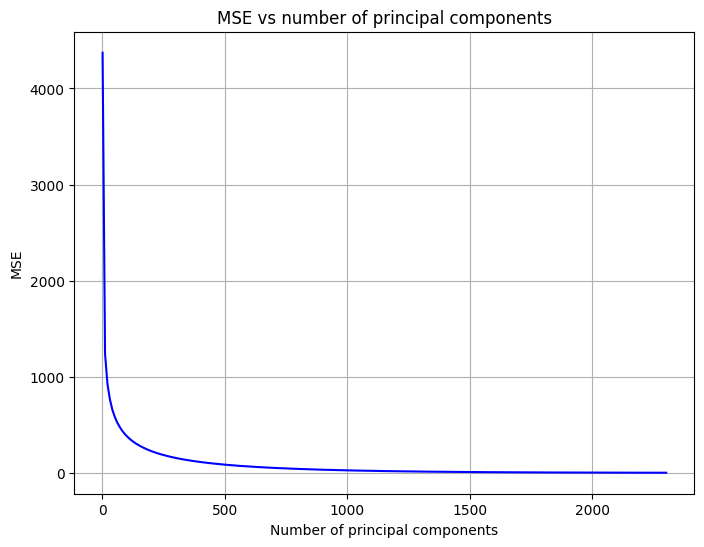

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate MSE for each k value
def calculate_mse(image_matrix, images, sorted_eigenvectors, k_values):
    mse_values = []
    
    # Loop through each k and calculate the MSE
    for k in k_values:
        # Select top k eigenvectors
        top_k_eigenvectors = sorted_eigenvectors[:, :k]
        
        # Project data onto the top k eigenvectors
        projected_data = np.dot(image_matrix, top_k_eigenvectors)
        
        # Reconstruct the images using the top k components
        reconstructed_images = np.dot(projected_data, top_k_eigenvectors.T).real.astype(np.float32)
        reconstructed_images = reconstructed_images.reshape(images.shape)  # Reshape to original image dimensions
        
        # Calculate the Mean Squared Error (MSE) between original and reconstructed images
        mse = np.mean((images - reconstructed_images) ** 2)
        mse_values.append(mse)
    
    return mse_values

# Function to plot MSE vs number of principal components
def plot_mse_vs_k(k_values, mse_values):
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, mse_values, color='blue')
    plt.title('MSE vs number of principal components')
    plt.xlabel('Number of principal components')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.show()

# Example usage
k_values = np.arange(1, 2304, 10)  # Choose a range of k values (number of principal components)
mse_values = calculate_mse(image_matrix, images, sorted_eigenvectors, k_values)
plot_mse_vs_k(k_values, mse_values)
